The MIT License (MIT)

Copyright (c) 2026 Martin Ladecký, Ivana Pultarová, François Bignonnet, Indre Jödicke, Jan Zeman, Lars Pastewka

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


# Mesh Size Dependency - Elasticity
This notebook investigates the mesh size dependency of the Jacobi-accelerated FFT-based solver for 2D linear elasticity. 
It evaluates the number of PCG iterations required for convergence as a function of the grid size (N) for two types of inclusion geometries:
1. **Sharp Data**: A geometry with a sharp material interface loaded from `cos_geometry_pixels=8dof=N.npy`.
2. **Smooth Data**: A geometry with a smooth material interface loaded from `cos_geometry_pixels=Ndof=N.npy`.

We compare three preconditioners:
- **Green Preconditioner**
- **Jacobi Preconditioner**
- **Green-Jacobi Preconditioner**


In [12]:
import os
import numpy as np
import scipy as sc
import scipy.sparse.linalg as sp
import matplotlib.pyplot as plt
%matplotlib inline


## Utility Functions


In [13]:
def get_shape_function_gradients(discretization_type, pixel_size):
    if discretization_type == 'linear_triangles':
        ndim = 2
        nb_quad = 2
        dx, dy = pixel_size
        B = np.zeros([ndim, nb_quad, 4])
        B[:, 0, :] = [[-1 / dx, 0, 1 / dx, 0],
                      [-1 / dy, 1 / dy, 0, 0]]
        B[:, 1, :] = [[0, -1 / dx, 0, 1 / dx],
                      [0, 0, -1 / dy, 1 / dy]]
        weights = np.array([dx * dy / 2, dx * dy / 2])
        return B.reshape(ndim, nb_quad, 2, 2), weights

def get_gradient_operators(pixel_size, N, dofs_per_node):
    ndim = 2
    B_dqij, weights = get_shape_function_gradients('linear_triangles', pixel_size)
    nb_quad = weights.size

    def B_op(u_ixy):
        grad_u_ijqxy = np.zeros([dofs_per_node, ndim, nb_quad, *N])
        for pixel_node in np.ndindex(2, 2):
            grad_u_ijqxy += np.einsum('jq,ixy...->ijqxy...',
                                      B_dqij[(..., *pixel_node)],
                                      np.roll(u_ixy, -1 * np.array(pixel_node), axis=tuple(range(1, ndim + 1))),
                                      optimize='optimal')
        return grad_u_ijqxy

    def Bw_t_op(flux_ijqxyz):
        div_flux_ixy = np.zeros([dofs_per_node, *N])
        flux_weighted = np.einsum('ijq...,q->ijq...', flux_ijqxyz, weights, optimize='optimal')
        for pixel_node in np.ndindex(2, 2):
            div_fnxyz_pixel_node = np.einsum('jq,ijqxy...->ixy...',
                                             B_dqij[(..., *pixel_node)],
                                             flux_weighted, optimize='optimal')
            div_flux_ixy += np.roll(div_fnxyz_pixel_node, 1 * np.array(pixel_node), axis=tuple(range(1, ndim + 1)))
        return div_flux_ixy

    return B_op, Bw_t_op, weights

def apply_smoother_log10(phase):
    kernel = np.array([[0.0625, 0.125, 0.0625],
                       [0.125, 0.25, 0.125],
                       [0.0625, 0.125, 0.0625]])
    smoothed_arr = sc.signal.convolve2d(np.log10(phase[0]), kernel, mode='same', boundary='wrap')
    smoothed_arr[0, :] = 0
    smoothed_arr[-1, :] = 0
    smoothed_arr[:, 0] = 0
    smoothed_arr[:, -1] = 0
    return 10 ** smoothed_arr


## Mesh Dependency Loop


In [14]:
grid_sizes = [8,16, 32, 64, 128,256,512,1024]#, 256
contrast = 1e-4
nb_quad_points_per_pixel = 2
ndim = 2

results = {
    'sharp': {'G': [], 'J': [], 'GJ': []},
    'smooth': {'G': [], 'J': [], 'GJ': []}
}

for N_val in grid_sizes:
    N = (N_val, N_val)
    pixel_size = (1/N_val, 1/N_val)
    n_u_dofs = ndim
    ndof = n_u_dofs * np.prod(N)
    displacement_shape = (ndim,) + N
    grad_shape = (ndim, ndim, nb_quad_points_per_pixel) + N

    # Operators
    dot21 = lambda A, v: np.einsum('ij...,j...->i...', A, v)
    ddot42 = lambda A, B: np.einsum('ijkl...,lk...->ij...', A, B)
    fft = lambda x: np.fft.fftn(x, [*N])
    ifft = lambda x: np.fft.ifftn(x, [*N])
    B, Bw_t, _ = get_gradient_operators(pixel_size, N, n_u_dofs)

    # Material Constants
    i = np.eye(ndim)
    I4s = (np.einsum('il,jk', i, i) + np.einsum('ik,jl', i, i)) / 2.
    II = np.einsum('ij,kl', i, i)

    # Stiffness parameters
    K_0 = 1.,   # bulk modulus
    mu_0 = 0.5  # shear modulus
    K4_0 = K_0 * II + 2. * mu_0 * (I4s - 1. / 3. * II)

    for mode in ['sharp', 'smooth']:
        print(f"Processing Grid {N_val}x{N_val}, Mode: {mode}")
        
        # Phase distribution
        if mode == 'sharp':
            filename = f'cos_geometry_pixels=8dof={N_val}.npy'
        else:
            filename = f'cos_geometry_pixels={N_val}dof={N_val}.npy'
        
        try:
            geometry = np.load(os.path.join('../data', filename))
        except FileNotFoundError:
            geometry = np.load(os.path.join('data', filename))

        phase = np.ones([nb_quad_points_per_pixel, *N])
        # Use geometry and apply contrast
        # Assuming geometry is 0 or 1, and we want to scale it.
        # Based on previous notebooks, phase is typically scaled.
        # The user said "Use geometries from data folder: ... for sharp data and ... for smooth data"
        # I'll use it to define the phase.
        phase[:, ...] = np.abs(geometry)
        phase[:] += contrast

        #phase = np.where(phase < 0.5, contrast, 1.0)

        mat_data_ijklqxy = np.einsum('ijkl,qxy...', K4_0, phase)

        # Loading
        macro_grad_ij = np.zeros([n_u_dofs, ndim])
        macro_grad_ij[0, 0] = 1
        macro_grad_ij[1, 1] = 1
        E_ijqxy = np.zeros(grad_shape)
        E_ijqxy += macro_grad_ij[(slice(None), slice(None)) + (np.newaxis,) * (len(E_ijqxy.shape) - 2)]

        K_fun_I = lambda x: Bw_t(ddot42(mat_data_ijklqxy, B(u_ixy=x.reshape(displacement_shape)))).reshape(-1)
        b_I = -Bw_t(ddot42(mat_data_ijklqxy, E_ijqxy)).reshape(-1)

        # 1. Green's Preconditioner
        ref_mat_data_ijkl = K4_0
        K_ref_fun = lambda x: Bw_t(ddot42(ref_mat_data_ijkl, B(u_ixy=x.reshape(displacement_shape))))
        G_diag_ijxy = np.zeros([n_u_dofs, n_u_dofs, *N])
        for d in range(n_u_dofs):
            unit_impuls_ixy = np.zeros(displacement_shape)
            unit_impuls_ixy[(d,) + ndim * (0,)] = 1
            G_diag_ijxy[:, d, ...] = K_ref_fun(x=unit_impuls_ixy)
        G_diag_ijxy = np.real(fft(x=G_diag_ijxy))
        reshaped_matrices = G_diag_ijxy.reshape(n_u_dofs, n_u_dofs, -1)
        G_batch = reshaped_matrices.transpose(2, 0, 1)
        G_batch[1:, ...] = np.linalg.inv(G_batch[1:, ...])
        M_diag_ijxy = G_batch.transpose(1, 2, 0).reshape(n_u_dofs, n_u_dofs, *N)
        Green_fun_I = lambda x: np.real(ifft(dot21(M_diag_ijxy, fft(x=x.reshape(displacement_shape))))).reshape(-1)

        # 2. Jacobi Preconditioner
        Jacobi_diag_ixy = np.zeros([n_u_dofs, *N])
        for d_i in range(ndim):
            for x_i in range(2):
                for y_i in range(2):
                    comb_impuls_ixy = np.zeros(displacement_shape)
                    comb_impuls_ixy[d_i, x_i::2, y_i::2] = 1.0
                    comb_impuls_ixy = K_fun_I(x=comb_impuls_ixy).reshape(displacement_shape)
                    Jacobi_diag_ixy[d_i, x_i::2, y_i::2] = np.where(
                        comb_impuls_ixy[d_i, x_i::2, y_i::2] != 0.,
                        1 / np.sqrt(comb_impuls_ixy[d_i, x_i::2, y_i::2]), 1.)
        Jacobi_fun = lambda x: Jacobi_diag_ixy * Jacobi_diag_ixy * x.reshape(displacement_shape)

        # 3. Green-Jacobi Preconditioner
        GreenJacobi_fun = lambda x: (Jacobi_diag_ixy * Green_fun_I(Jacobi_diag_ixy * x.reshape(displacement_shape)).reshape(displacement_shape))

        # Solves
        def solve(M_fun):
            num_iters = 0
            def callback(xk): nonlocal num_iters; num_iters += 1
            _, _ = sp.cg(sp.LinearOperator((ndof, ndof), K_fun_I), b_I, M=sp.LinearOperator((ndof, ndof), M_fun), atol=1e-5,rtol=1e-15, maxiter=999, callback=callback)
            return num_iters

        results[mode]['G'].append(solve(Green_fun_I))
        results[mode]['J'].append(solve(Jacobi_fun))
        results[mode]['GJ'].append(solve(GreenJacobi_fun))
        
        print(f"  Iterations: G={results[mode]['G'][-1]}, J={results[mode]['J'][-1]}, GJ={results[mode]['GJ'][-1]}")


Processing Grid 8x8, Mode: sharp
  Iterations: G=10, J=12, GJ=5
Processing Grid 8x8, Mode: smooth
  Iterations: G=10, J=12, GJ=5
Processing Grid 16x16, Mode: sharp
  Iterations: G=20, J=26, GJ=7
Processing Grid 16x16, Mode: smooth
  Iterations: G=22, J=25, GJ=5
Processing Grid 32x32, Mode: sharp
  Iterations: G=23, J=55, GJ=11
Processing Grid 32x32, Mode: smooth
  Iterations: G=43, J=51, GJ=5
Processing Grid 64x64, Mode: sharp
  Iterations: G=24, J=101, GJ=19
Processing Grid 64x64, Mode: smooth
  Iterations: G=81, J=87, GJ=5
Processing Grid 128x128, Mode: sharp
  Iterations: G=26, J=194, GJ=26
Processing Grid 128x128, Mode: smooth
  Iterations: G=142, J=144, GJ=4
Processing Grid 256x256, Mode: sharp
  Iterations: G=27, J=317, GJ=49
Processing Grid 256x256, Mode: smooth
  Iterations: G=217, J=277, GJ=4
Processing Grid 512x512, Mode: sharp
  Iterations: G=28, J=611, GJ=90
Processing Grid 512x512, Mode: smooth
  Iterations: G=305, J=542, GJ=3
Processing Grid 1024x1024, Mode: sharp
  Itera

## Results Visualization


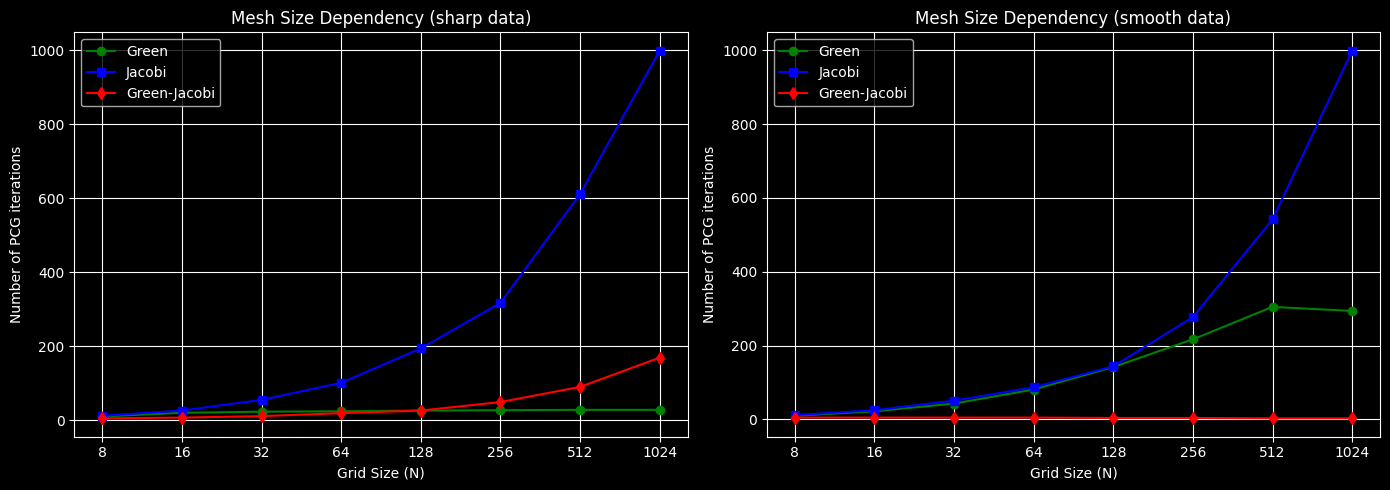

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for mode, ax in zip(['sharp', 'smooth'], [ax1, ax2]):
    ax.plot(grid_sizes, results[mode]['G'], 'g-o', label='Green')
    ax.plot(grid_sizes, results[mode]['J'], 'b-s', label='Jacobi')
    ax.plot(grid_sizes, results[mode]['GJ'], 'r-d', label='Green-Jacobi')
    ax.set_title(f'Mesh Size Dependency ({mode} data)')
    ax.set_xlabel('Grid Size (N)')
    ax.set_ylabel('Number of PCG iterations')
    ax.legend()
    ax.grid(True)
    ax.set_xscale('log', base=2)
    ax.set_xticks(grid_sizes)
    # Use ScalarFormatter to show actual grid size values
    from matplotlib.ticker import ScalarFormatter
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.get_xaxis().set_tick_params(which='minor', size=0)
    ax.get_xaxis().set_tick_params(which='minor', labelbottom=False)

plt.tight_layout()
plt.savefig('../figures/mesh_size_dependency.png')
plt.show()
